<a href="https://colab.research.google.com/github/samiraabnar/attention_flow/blob/master/bert_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install transformers

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
!ls

attention_graph_util.py		 correlation_logs	 rat_bert_att_2.png
bert_example.ipynb		 distilbert_sst.ipynb	 rat_bert_bar_2.png
bert_sv.ipynb			 distill_bert_viz.ipynb  README.md
bert_viz.ipynb			 graphs			 run_bert_sv.py
compute_corel_distilbert_sst.py  __pycache__		 utils


In [49]:
# !git clone https://github.com/samiraabnar/attention_flow

In [50]:
%cd gdrive/My Drive/attention_flow/

[Errno 2] No such file or directory: 'gdrive/My Drive/attention_flow/'
/content/gdrive/My Drive/attention_flow


In [51]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from attention_graph_util import *
import seaborn as sns
import itertools 
import matplotlib as mpl

rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G


In [52]:
pretrained_weights = 'bert-base-uncased'
model = AutoModelForMaskedLM.from_pretrained(pretrained_weights,
                                             output_hidden_states=True,
                                             output_attentions=True)
model.zero_grad()
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
sentences = {}
src = {}
targets = {}
sentences[1] = "She asked the doctor about "+tokenizer.mask_token+" backache"
src[1] = 6
targets[1] = (1,4) 
sentences[0] = "He talked to her about his book"
src[0] = 6
targets[0] = (1,4) 
sentences[2] = "The author talked to Sara about "+tokenizer.mask_token+" book"
src[2] = 7
targets[2] = (2,5) 

sentences[3] = "John tried to convince Mary of his love and brought flowers for "+tokenizer.mask_token
src[3] = 13
targets[3] = (1,5) 

sentences[4] = "Mary convinced John of "+tokenizer.mask_token+" love"
src[4] = 5
targets[4] = (1,3) 

ex_id = 2
sentence = sentences[ex_id]
tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']
print(len(tokens), tokens)
tf_input_ids = tokenizer.encode(sentence)
print(tokenizer.decode(tf_input_ids))
input_ids = torch.tensor([tf_input_ids])
model_outputs = model(input_ids)
all_hidden_states, all_attentions =  model_outputs['hidden_states'],  model_outputs['attentions']

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

10 ['[cls]', 'the', 'author', 'talked', 'to', 'sara', 'about', '[MASK]', 'book', '[sep]']
[CLS] the author talked to sara about [MASK] book [SEP]
(12, 12, 10, 10)


In [54]:
output = model(input_ids)[0]
predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])

print(np.argmax(output.detach().numpy()[0], axis=-1))
print(tokenizer.decode(np.argmax(output.detach().numpy()[0], axis=-1)))
print(tf_input_ids[src[ex_id]], tokenizer.decode([tf_input_ids[src[ex_id]]]))
print(tf_input_ids[targets[ex_id][0]], tokenizer.decode([tf_input_ids[targets[ex_id][0]]]), predicted_target[tf_input_ids[targets[ex_id][0]]])
print(tf_input_ids[targets[ex_id][1]], tokenizer.decode([tf_input_ids[targets[ex_id][1]]]), predicted_target[tf_input_ids[targets[ex_id][1]]])

his_id = tokenizer.encode('his')[1]
her_id = tokenizer.encode('her')[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id], "her prob:", predicted_target[her_id], "her?", predicted_target[her_id] > predicted_target[his_id])

[1012 1996 3166 5720 2000 7354 2055 1996 1012 1012]
. the author talked to sara about the..
103 [MASK]
3166 author tensor(5.9873e-06, grad_fn=<SelectBackward>)
7354 sara tensor(5.9435e-07, grad_fn=<SelectBackward>)
2010 2014
his prob: tensor(0.0700, grad_fn=<SelectBackward>) her prob: tensor(0.1019, grad_fn=<SelectBackward>) her? tensor(True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


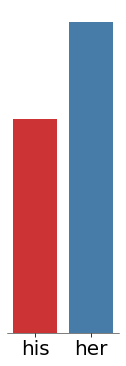

In [55]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['his', 'her'], [float(predicted_target[his_id].detach()), float(predicted_target[her_id].detach())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

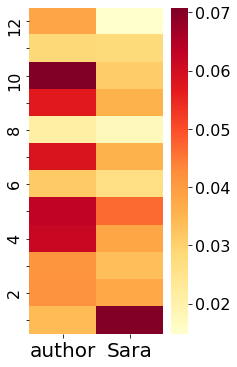

In [56]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('rat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

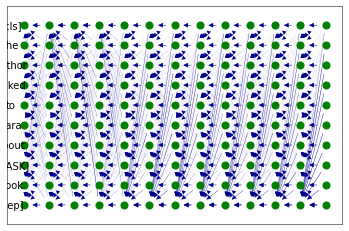

In [57]:
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

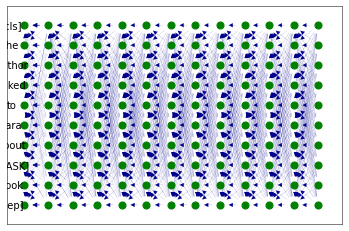

In [58]:
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

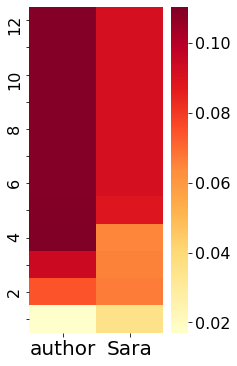

In [59]:
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('res_fat_bert_att_{}.png'.format(ex_id), format='png', transparent=True,dpi=360, bbox_inches='tight')

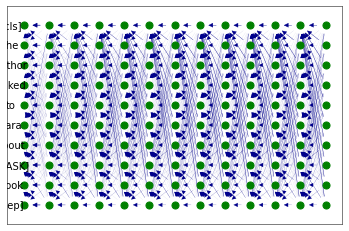

In [60]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

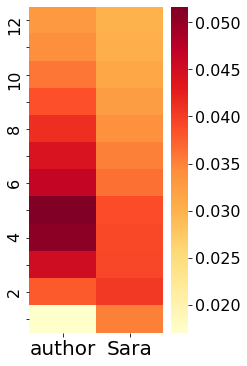

In [61]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('res_jat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')